In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [21]:
# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로그래밍/9주/Alcohol_Sales.csv')
data = df['S4248SM144NCEN'].values.reshape(-1,1)

In [22]:
# 2. 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [23]:
# 3. 시퀀스 생성
window = 12   # 최근 12개월 → 다음달 예측
X, y = [], []
for i in range(len(data)-window):
    X.append(data[i:i+window])
    y.append(data[i+window])
X, y = np.array(X), np.array(y)

In [24]:
# 4. Train / Test 분할 (8:2 비율)
split = int(len(X) * 0.8)  # 80%
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# RNN(LSTM) 입력 형태로 맞추기: (샘플 수, 타임스텝, 특성 수)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

In [25]:
print("데이터 분할 완료 ✅")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

데이터 분할 완료 ✅
X_train: (250, 12, 1)
y_train: (250, 1)
X_test: (63, 12, 1)
y_test: (63, 1)


In [26]:
# 5. RNN 모델 생성

rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(window,1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# 6. 컴파일
rnn_model.compile(
    optimizer='adam',
    loss='mse'   # 회귀 문제이므로 MSE 사용
)

In [28]:
# 7. 모델 학습 (Training)

history = rnn_model.fit(
    X_train, y_train,
    epochs=50,           # 학습 반복 횟수
    batch_size=16,       # 배치 크기
    validation_data=(X_test, y_test),  # 검증 데이터
    verbose=1
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0885 - val_loss: 0.0131
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0074 - val_loss: 0.0131
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 0.0092
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012 - val_loss: 0.0104
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0117
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 0.0146
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0115
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0111
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 0.0082
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.8955e-04 - val_loss: 0.0089
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss:

In [29]:
# 8. 모델 평가

loss = rnn_model.evaluate(X_test, y_test)
print(f"\n최종 테스트 손실(MSE): {loss:.6f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0066

최종 테스트 손실(MSE): 0.007644


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


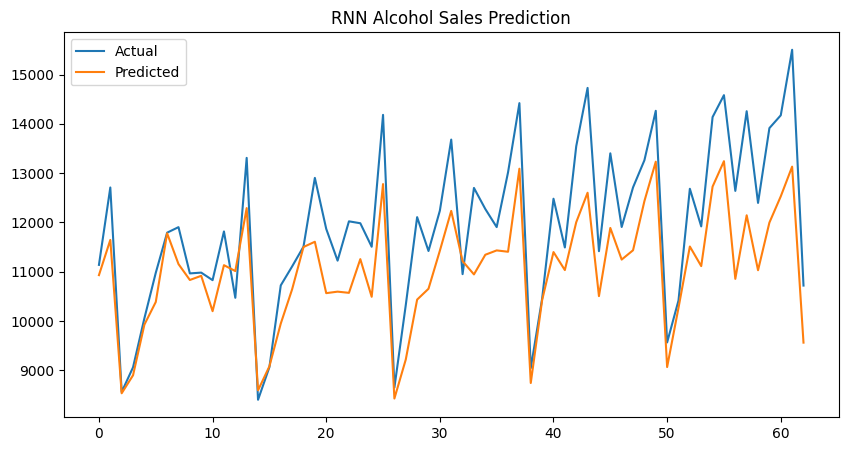

In [30]:
# 9. 예측 및 시각화
y_pred = rnn_model.predict(X_test)

# 역정규화 (예측값을 원래 스케일로 되돌리기)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('RNN Alcohol Sales Prediction')
plt.legend()
plt.show()

In [36]:
# 5-2. LSTM 모델 생성

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window,1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# 6-2. 컴파일

lstm_model.compile(
    optimizer='adam',
    loss='mse'
)

In [38]:
# 7-2. 학습

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0719 - val_loss: 0.0141
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0094 - val_loss: 0.0194
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0055 - val_loss: 0.0158
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0055 - val_loss: 0.0148
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0051 - val_loss: 0.0138
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0052 - val_loss: 0.0140
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0048 - val_loss: 0.0151
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051 - val_loss: 0.0142
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0049 - val_loss: 0.0140
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0046 - val_loss: 0.0136
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0042 - val_loss: 0.0142
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

In [39]:
# 8-2. 평가

loss = lstm_model.evaluate(X_test, y_test)
print(f"\n최종 테스트 손실(MSE): {loss:.6f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0103

최종 테스트 손실(MSE): 0.010687


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


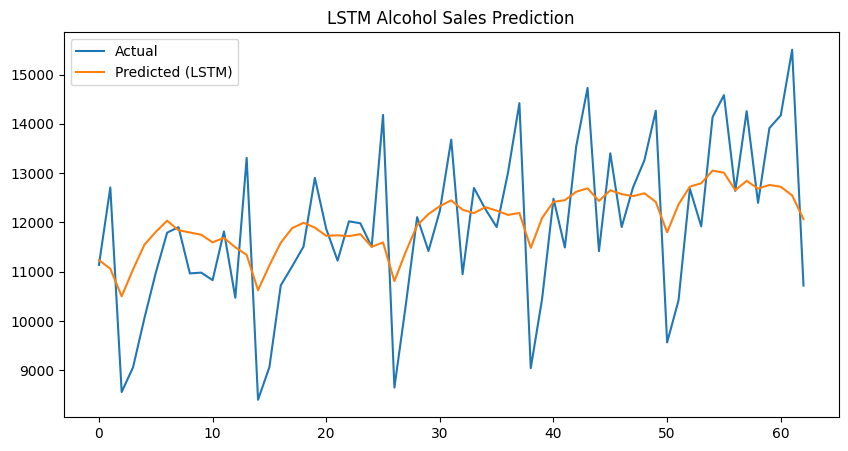

In [40]:
# 9-2. 시각화

y_pred = lstm_model.predict(X_test)

# 역정규화
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted (LSTM)')
plt.title('LSTM Alcohol Sales Prediction')
plt.legend()
plt.show()